## Brain MRI Project

For this project we will use some images of Brain MRIs and we will build a model that knows how to identify between the 4 classes that the images belong to.

The dataset is from [Kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?select=Training). 
<br>It contains 7023 images, belonging to 4 different classes:  glioma - meningioma - no tumor and pituitary.
<br>Let us proceed with our imports and previewing the images.

#### Imports

In [1]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme(style="white")

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm
from scikeras.wrappers import KerasClassifier
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage import io
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

#### Creating the datasets

In [2]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=5712)


# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


Previewing an image from the train set:

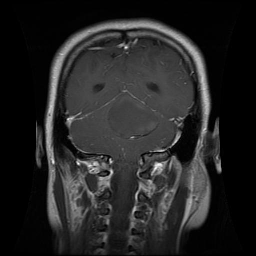

In [3]:
# Preview an image
array_to_img(train_images[0])

Previewing an image from the test set:

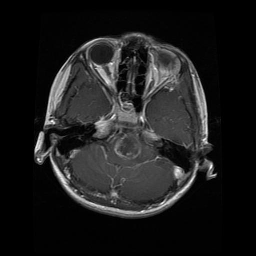

In [4]:
# Preview an image
array_to_img(test_images[0])

Now let us explore more the division among the classes and we will preview one image per class.

In [5]:
test_images.shape

(1311, 256, 256, 3)

In [6]:
train_images.shape

(5712, 256, 256, 3)

This shows us that the dimension of the imgaes is 256x256 and the sample that was taken from the image generator contains all the images for train and test.

Now we will generate a dataframe for the train images, first let us look at the classes:

In [7]:
train_generator.class_indices 

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [8]:
df_train=pd.DataFrame(train_labels, columns=['glioma', 'meningioma',\
            'notumor', 'pituitary'])

Let us preview it:

In [9]:
df_train

,glioma,meningioma,notumor,pituitary
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
5707,0.0,0.0,0.0,1.0
5708,0.0,0.0,0.0,1.0
5709,1.0,0.0,0.0,0.0
5710,0.0,0.0,0.0,1.0


In [10]:
df_train.value_counts()

glioma  meningioma  notumor  pituitary
0.0     0.0         1.0      0.0          1595
                    0.0      1.0          1457
        1.0         0.0      0.0          1339
1.0     0.0         0.0      0.0          1321
dtype: int64

In [11]:
sums=df_train.sum(axis=0)
sums=pd.DataFrame(sums)
sums.rename(columns={0: "Counts"}, inplace=True)
sums

,Counts
glioma,1321.0
meningioma,1339.0
notumor,1595.0
pituitary,1457.0


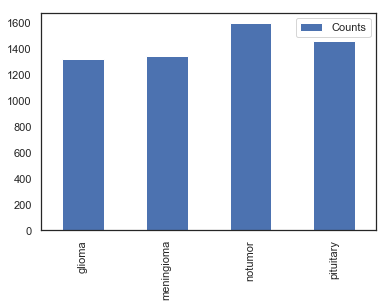

In [12]:
sums['Counts'].plot(kind='bar', legend=True);

#### Repeating for the test:

In [13]:
test_generator.class_indices 

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [14]:
df_test=pd.DataFrame(test_labels, columns=['glioma', 'meningioma',\
            'notumor', 'pituitary'])

In [15]:
df_test

,glioma,meningioma,notumor,pituitary
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
1306,1.0,0.0,0.0,0.0
1307,0.0,0.0,1.0,0.0
1308,0.0,0.0,0.0,1.0
1309,1.0,0.0,0.0,0.0


In [16]:
sums_test=df_test.sum(axis=0)
sums_test=pd.DataFrame(sums_test)
sums_test.rename(columns={0: "Counts"}, inplace=True)
sums_test

,Counts
glioma,300.0
meningioma,306.0
notumor,405.0
pituitary,300.0


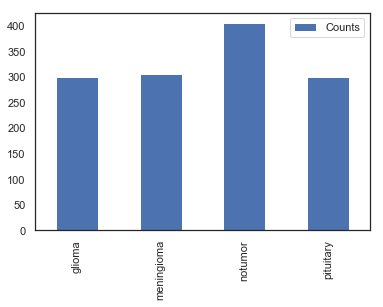

In [17]:
sums_test['Counts'].plot(kind='bar', legend=True);

Now that we saw the distribution of the images we can say that the classes are pretty well balanced and hopefully we shouldn't have problems of imbalanced classes.

Next we need to do some data manipulation to prepare the labels to be used when we run and fit the model.
As we saw right now the labels for each class are all the same, '1'. But we will have to collapse the labels into one dimensional array to be able to feed it to the model, so we need to assign different labels to each class to be able to distinguish between them. We will do this by simply creating a dictionary and reassigning the labels.

In [18]:
df_train.replace({'notumor': 1.0}, 0, inplace=True)
df_train.replace({'glioma': 1.0}, 1, inplace=True)
df_train.replace({'meningioma': 1.0}, 2, inplace=True)
df_train.replace({'pituitary': 1.0}, 3, inplace=True)

In [19]:
df_train

,glioma,meningioma,notumor,pituitary
0,1.0,0.0,0.0,0.0
1,0.0,2.0,0.0,0.0
2,0.0,0.0,0.0,3.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
5707,0.0,0.0,0.0,3.0
5708,0.0,0.0,0.0,3.0
5709,1.0,0.0,0.0,0.0
5710,0.0,0.0,0.0,3.0


Creating a new column '1D' that will be our 1 dimensional array of labels.

In [20]:
df_train['1D']=df_train['glioma']+df_train['meningioma']+df_train['notumor']+df_train['pituitary']

In [21]:
df_train

,glioma,meningioma,notumor,pituitary,1D
0,1.0,0.0,0.0,0.0,1.0
1,0.0,2.0,0.0,0.0,2.0
2,0.0,0.0,0.0,3.0,3.0
3,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
5707,0.0,0.0,0.0,3.0,3.0
5708,0.0,0.0,0.0,3.0,3.0
5709,1.0,0.0,0.0,0.0,1.0
5710,0.0,0.0,0.0,3.0,3.0


Now we just need to turn this column into a numpy array and that will be perfect to be used as the y in our model:

In [22]:
train_y=df_train['1D'].to_numpy()
train_y

array([1., 2., 3., ..., 1., 3., 0.], dtype=float32)

Repeating the same steps for the test:

In [23]:
df_test.replace({'notumor': 1.0}, 0, inplace=True)
df_test.replace({'glioma': 1.0}, 1, inplace=True)
df_test.replace({'meningioma': 1.0}, 2, inplace=True)
df_test.replace({'pituitary': 1.0}, 3, inplace=True)

In [24]:
df_test['1D']=df_test['glioma']+df_test['meningioma']+df_test['notumor']+df_test['pituitary']

In [25]:
test_y=df_test['1D'].to_numpy()
test_y

array([1., 1., 0., ..., 3., 1., 3.], dtype=float32)

Perfect, now we are almost ready to start making and running our models.

#### Building some functions:

Building some functions that will help us visualize and compare the different models.
The first function we are defining is to visualize the curve of accuracy and loss, as they develop along the epochs, both for the train and validation set.
We are extracting these values from the history that the model produces once it is fit.

In [26]:
def visualize_training_results(results):
#Extracting the history from the results of the model
    history = results.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
#Plotting Train and Validation Accuracy
    ax1.plot(history['val_acc'])
    ax1.plot(history['acc'])
#Setting legend, title and labels
    ax1.legend(['val_acc', 'acc'], loc='best')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
#Plotting Train and Validation Loss    
    ax2.plot(history['val_loss'])
    ax2.plot(history['loss'])
#Setting legend, title and labels
    ax2.legend(['val_loss', 'loss'], loc='best')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

Defining a function to fit the model and get the results. Also here we can set number of epochs, batch size and validation split, but there are default parameters too. In particular we set verbose to zero because we don't want to print out the fitting of all the models. We also set a default validation split of 20%, which is a standard amount, to have a part of the data that the model can do validation on.

In [27]:
#Defining function with some sest parameters
def fit_model(model, X, y, epo=15, batch=30, val_split=0.2, verbose=0):
    #Fitting the model and storing the results in the variable 'results'
    results = model.fit(X, y, epochs=epo, batch_size=batch, 
                        validation_split=val_split, verbose=verbose)
    return results

At last we are going to be creating a function to preview and store the results of our models. With this function we will display the evolution of accuracy and loss in our model, during the different epochs.
Below that we will see also the values of accuracy and loss and over time we will build a learning curve, adding the result of each previous model and the current one, to see if our model is improving.
We are also saving the results into a DataFrame that we will keep updating with the new results, to have them also in a convenient tabular format.

In [28]:
#Defining the function
def model_results(model, results, model_name, df, trainX, trainy ):
    #First we want the function to display the history of accuracy and loss, with the function previously defined
    visualize_training_results(results)
    #Creating a temporary DataFrame to store the results obtained
    df1 = pd.DataFrame({'Name': [model_name],
        'accuracy train': results.history['acc'][-1] ,
        'accuracy validation': results.history['val_acc'][-1],
        'loss train': results.history['loss'][-1],
        'loss validation': results.history['val_loss'][-1]})
    #Appending the results of the current model to the general DataFrame 'df' with results of all models
    df=df.append(df1)
    #Plotting learning curves of Accuracy and Loss
    fig = plt.subplots(figsize=(12,6))
    #First Subplot, accuracy of train and validation
    #This takes resulta from df, plotting the results from current and previous models
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='c')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='m')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
    #Second Subplot, loss of train and validation
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='c')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='m')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df

Next we are going to build a first naive CNN model that we will use as our baseline or naive model.

#### Naive Model:

Importing Images:

In [29]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir,target_size=(16, 16), batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(16, 16),batch_size=5712)


# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

# Normalizing the data
train_images /= 255.
test_images /= 255.

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


Creating a first basic model.
This model will have images of size 16x16 as input, and only one convolutional layer with 3 neurons, and one pooling layer.
The final Dense layer has to have 4 neurons because that corresponds with the number of classes that we are trying to identify for our images.

In [30]:
# create model
#Sequential: multiple layers built on top of each other

model = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(16,16,3)))
#MaxPooling with filter size 2 and stride 2
model.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Fitting the model:

In [31]:
history = fit_model(model, train_images, train_y, epo=10, batch=10, verbose=1)

Epoch 1/10
457/457 [==============================] - 4s 7ms/step - loss: 1.3877 - acc: 0.2552 - val_loss: 1.3836 - val_acc: 0.2765
Epoch 2/10
457/457 [==============================] - 1s 3ms/step - loss: 1.3848 - acc: 0.2792 - val_loss: 1.3834 - val_acc: 0.2808
Epoch 3/10
457/457 [==============================] - 1s 3ms/step - loss: 1.3800 - acc: 0.2912 - val_loss: 1.3841 - val_acc: 0.2572
Epoch 4/10
457/457 [==============================] - 2s 3ms/step - loss: 1.3785 - acc: 0.2993 - val_loss: 1.3846 - val_acc: 0.2738
Epoch 5/10
457/457 [==============================] - 2s 3ms/step - loss: 1.3762 - acc: 0.2959 - val_loss: 1.3851 - val_acc: 0.2721
Epoch 6/10
457/457 [==============================] - 1s 3ms/step - loss: 1.3744 - acc: 0.2917 - val_loss: 1.3861 - val_acc: 0.2721
Epoch 7/10
457/457 [==============================] - 2s 4ms/step - loss: 1.3752 - acc: 0.2877 - val_loss: 1.3892 - val_acc: 0.2563
Epoch 8/10
457/457 [==============================] - 4s 9ms/step - loss: 1.

Creating an empty dataframe to store the results:

In [32]:
df_res=pd.DataFrame()

Saving and previewing the results:

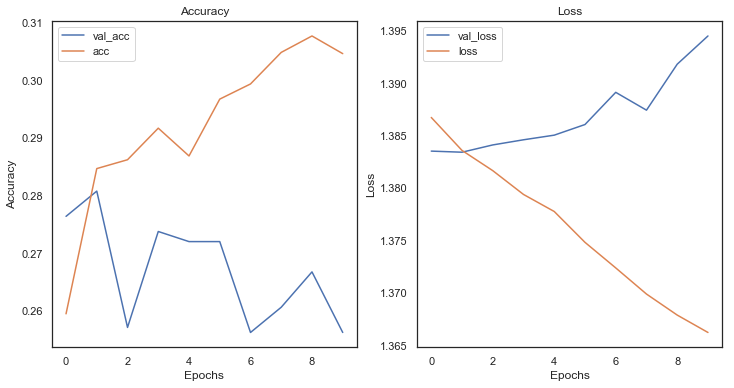

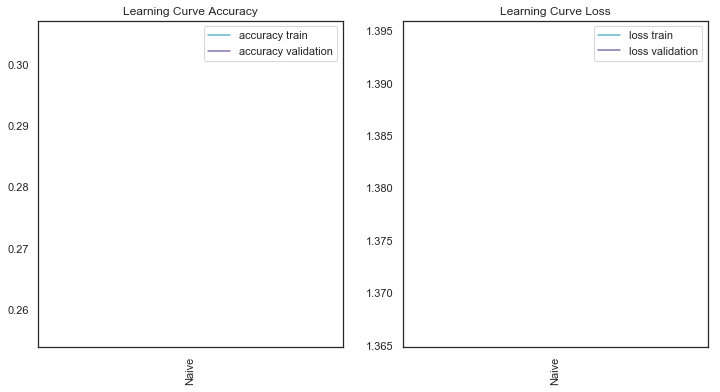

In [33]:
df_res=model_results(model, history, 'Naive', df_res, train_images, train_labels)

In [34]:
df_res

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.304662,0.256343,1.366258,1.394532


This is a very primitive model so we expect the results to not be particularly good.
Given that there are 4 possible classes, the accuracy of a "random" model (choosing the class of the image completely at random) would be around 25%, which is what we are seeing here.
Now we will take the necessary steps to try and improve the performance of our model.

#### Increasing Image Size
The first thing that we should reasonably do is to increase the image size, we will import the images again this time with size 32x32.

In [35]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir,target_size=(32, 32), batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(32, 32),batch_size=5712)


# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

# Normalizing the data
train_images /= 255.
test_images /= 255.

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


Next we will create a model exactly like our previous one, but changing the input shape, so we are changing only one variable.

In [36]:
# create model
#Sequential: multiple layers built on top of each other

model = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(32,32,3)))
#MaxPooling with filter size 2 and stride 2
model.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [37]:
history1 = fit_model(model, train_images, train_y, epo=10, batch=10, verbose=1)

Epoch 1/10
457/457 [==============================] - 3s 6ms/step - loss: 1.4013 - acc: 0.2626 - val_loss: 1.3845 - val_acc: 0.2668
Epoch 2/10
457/457 [==============================] - 2s 5ms/step - loss: 1.3799 - acc: 0.2859 - val_loss: 1.3848 - val_acc: 0.2590
Epoch 3/10
457/457 [==============================] - 2s 5ms/step - loss: 1.3706 - acc: 0.2975 - val_loss: 1.3890 - val_acc: 0.2590
Epoch 4/10
457/457 [==============================] - 3s 6ms/step - loss: 1.3588 - acc: 0.3224 - val_loss: 1.3912 - val_acc: 0.2616
Epoch 5/10
457/457 [==============================] - 3s 7ms/step - loss: 1.3546 - acc: 0.3320 - val_loss: 1.3996 - val_acc: 0.2616
Epoch 6/10
457/457 [==============================] - 3s 7ms/step - loss: 1.3404 - acc: 0.3451 - val_loss: 1.4106 - val_acc: 0.2598
Epoch 7/10
457/457 [==============================] - 3s 6ms/step - loss: 1.3324 - acc: 0.3615 - val_loss: 1.4222 - val_acc: 0.2283
Epoch 8/10
457/457 [==============================] - 2s 5ms/step - loss: 1.

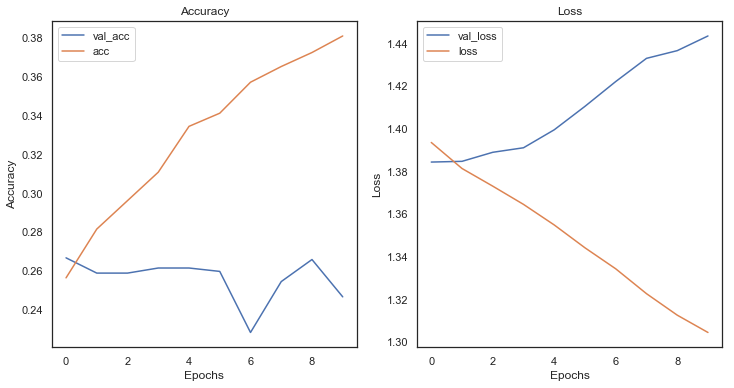

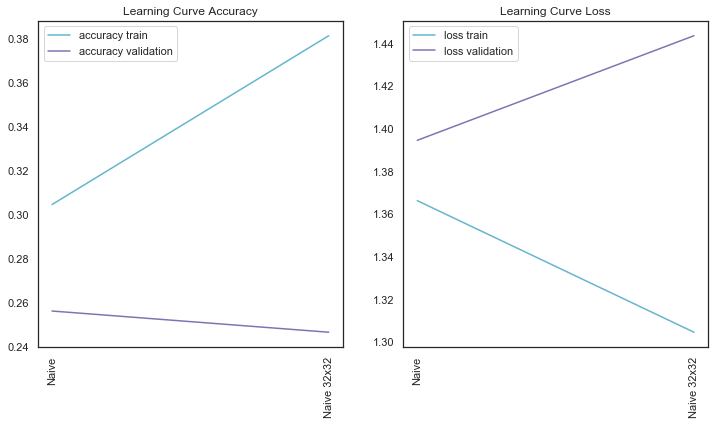

In [38]:
df_res=model_results(model, history1, 'Naive 32x32', df_res, train_images, train_labels)

We start to see the accuracy increasing for the train, which is encouraging. It did not increase for the validation but that might have to do with the very small batch (10 images) that we are using.
<br>We are first going to increase the images size further and then we will move on to changing the batch size and number of epochs.
<br>So let us proceed to increase the image size further, to 64x64.

In [39]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir,target_size=(64, 64), batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64),batch_size=5712)


# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

# Normalizing the data
train_images /= 255.
test_images /= 255.

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


Recreating the model:

In [40]:
# create model
#Sequential: multiple layers built on top of each other

model = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(64,64,3)))
#MaxPooling with filter size 2 and stride 2
model.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [41]:
history2 = fit_model(model, train_images, train_y, epo=10, batch=10, verbose=1)

Epoch 1/10
457/457 [==============================] - 6s 11ms/step - loss: 1.3953 - acc: 0.2615 - val_loss: 1.3831 - val_acc: 0.2747
Epoch 2/10
457/457 [==============================] - 5s 12ms/step - loss: 1.3734 - acc: 0.2985 - val_loss: 1.3853 - val_acc: 0.2756
Epoch 3/10
457/457 [==============================] - 5s 11ms/step - loss: 1.3467 - acc: 0.3497 - val_loss: 1.4008 - val_acc: 0.2520
Epoch 4/10
457/457 [==============================] - 5s 11ms/step - loss: 1.3204 - acc: 0.3706 - val_loss: 1.4129 - val_acc: 0.2668
Epoch 5/10
457/457 [==============================] - 5s 11ms/step - loss: 1.2888 - acc: 0.4096 - val_loss: 1.4380 - val_acc: 0.2668
Epoch 6/10
457/457 [==============================] - 5s 11ms/step - loss: 1.2569 - acc: 0.4162 - val_loss: 1.4432 - val_acc: 0.2730
Epoch 7/10
457/457 [==============================] - 5s 10ms/step - loss: 1.2332 - acc: 0.4451 - val_loss: 1.4728 - val_acc: 0.2765
Epoch 8/10
457/457 [==============================] - 5s 10ms/step - 

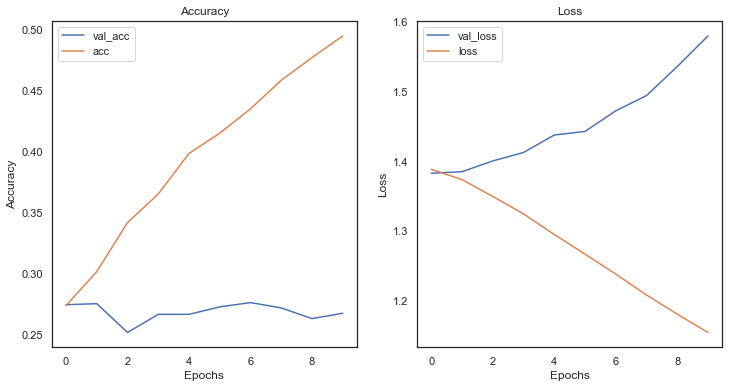

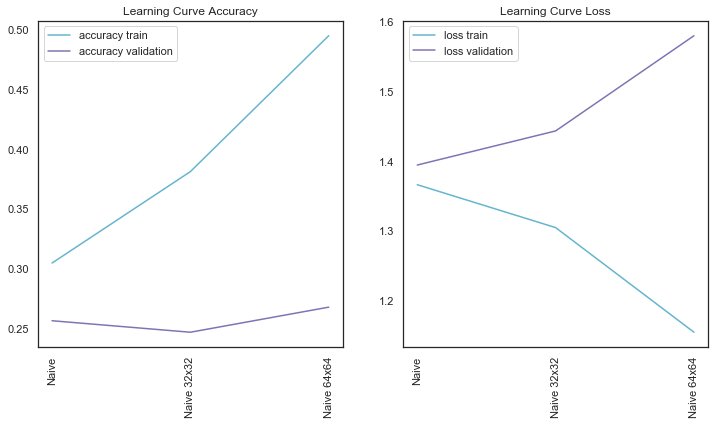

In [42]:
df_res=model_results(model, history2, 'Naive 64x64', df_res, train_images, train_y)

In [43]:
df_res

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.304662,0.256343,1.366258,1.394532
0,Naive 32x32,0.381265,0.246719,1.304591,1.443555
0,Naive 64x64,0.495075,0.267717,1.154185,1.580436


The results with this increase of size are have improved, but not tremendously.
<br>Importing images with size 132x132.

In [44]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir,target_size=(132,132), batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(132,132),batch_size=5712)


# Create the datasets
train_images132, train_labels = next(train_generator)
test_images132, test_labels = next(test_generator)

# Normalizing the data
train_images132 /= 255.
test_images132 /= 255.

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


Creating the model:

In [45]:
# create model
#Sequential: multiple layers built on top of each other

model132 = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(132,132,3)))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model132.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model132.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model132.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [46]:
history3 = fit_model(model132, train_images132, train_y, epo=10, batch=10, verbose=1)

Epoch 1/10
457/457 [==============================] - 16s 35ms/step - loss: 1.6717 - acc: 0.2516 - val_loss: 1.3844 - val_acc: 0.2765
Epoch 2/10
457/457 [==============================] - 15s 34ms/step - loss: 1.3652 - acc: 0.3067 - val_loss: 1.4041 - val_acc: 0.2791
Epoch 3/10
457/457 [==============================] - 15s 33ms/step - loss: 1.2958 - acc: 0.3996 - val_loss: 1.4592 - val_acc: 0.2660
Epoch 4/10
457/457 [==============================] - 15s 33ms/step - loss: 1.2135 - acc: 0.4633 - val_loss: 1.5090 - val_acc: 0.2668
Epoch 5/10
457/457 [==============================] - 15s 33ms/step - loss: 1.1257 - acc: 0.5372 - val_loss: 1.5987 - val_acc: 0.2668
Epoch 6/10
457/457 [==============================] - 15s 32ms/step - loss: 1.0293 - acc: 0.5899 - val_loss: 1.6590 - val_acc: 0.2765
Epoch 7/10
457/457 [==============================] - 15s 32ms/step - loss: 0.9566 - acc: 0.6408 - val_loss: 1.7812 - val_acc: 0.2703
Epoch 8/10
457/457 [==============================] - 15s 32ms

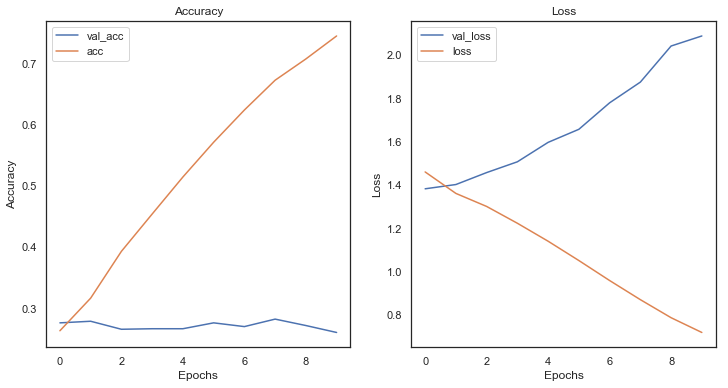

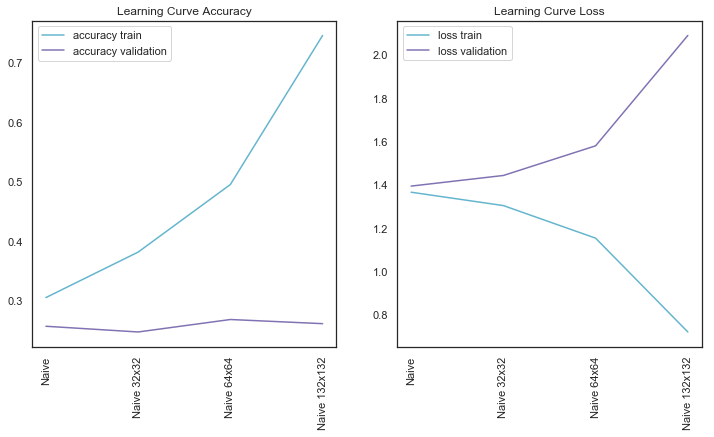

In [47]:
df_res=model_results(model132, history3, 'Naive 132x132', df_res, train_images132, train_y)

The results with the image size 132x132 show a great improvement but we start to see some overfitting.
<br>We will be able to handle this later in different ways. First let us try to increase the image size one more time to the full 256x256.

In [48]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir,target_size=(256,256), batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(256,256),batch_size=5712)


# Create the datasets
train_images256, train_labels = next(train_generator)
test_images256, test_labels = next(test_generator)

# Normalizing the data
train_images256 /= 255.
test_images256 /= 255.

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


In [49]:
# create model
#Sequential: multiple layers built on top of each other

model256 = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model256.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(256,256,3)))
#MaxPooling with filter size 2 and stride 2
model256.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model256.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model256.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model256.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [50]:
history4 = fit_model(model256, train_images256, train_y, epo=10, batch=10, verbose=1)

Epoch 1/10
457/457 [==============================] - 73s 153ms/step - loss: 1.6179 - acc: 0.2467 - val_loss: 1.3842 - val_acc: 0.2738
Epoch 2/10
457/457 [==============================] - 58s 126ms/step - loss: 1.3589 - acc: 0.3263 - val_loss: 1.4134 - val_acc: 0.2625
Epoch 3/10
457/457 [==============================] - 59s 128ms/step - loss: 1.3077 - acc: 0.3636 - val_loss: 1.5232 - val_acc: 0.2756
Epoch 4/10
457/457 [==============================] - 58s 126ms/step - loss: 1.2034 - acc: 0.4680 - val_loss: 1.6041 - val_acc: 0.2712
Epoch 5/10
457/457 [==============================] - 58s 127ms/step - loss: 1.0970 - acc: 0.5438 - val_loss: 1.7204 - val_acc: 0.2651
Epoch 6/10
457/457 [==============================] - 55s 121ms/step - loss: 0.9713 - acc: 0.6317 - val_loss: 1.9132 - val_acc: 0.2677
Epoch 7/10
457/457 [==============================] - 58s 127ms/step - loss: 0.8429 - acc: 0.6910 - val_loss: 2.0118 - val_acc: 0.2633
Epoch 8/10
457/457 [==============================] - 5

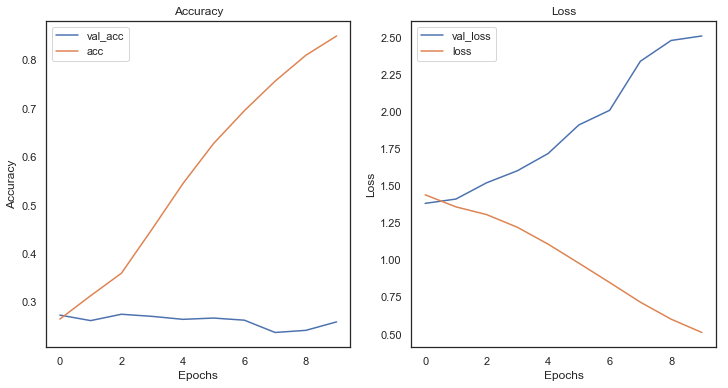

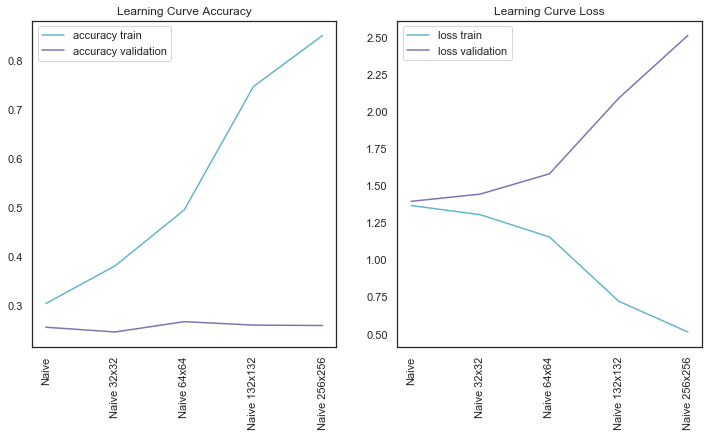

In [51]:
df_res=model_results(model256, history4, 'Naive 256x256', df_res, train_images256, train_y)

We can see how the performance has even further increased with the increase of the image size.
The issue with using larger images can be computational time but it definitely gives a chance to the model to learn at its best.
For now we will keep it this way, and start to increase number pf epochs and batch size.

#### Epochs and batch size
Let us see what happens if we keep our same model, but we give it a chance to learn over more epochs, and using a larger batch of images.

In [52]:
history5 = fit_model(model256, train_images256, train_y, epo=20, batch=20, verbose=1)

Epoch 1/20
229/229 [==============================] - 59s 255ms/step - loss: 0.4040 - acc: 0.8877 - val_loss: 2.7514 - val_acc: 0.2607
Epoch 2/20
229/229 [==============================] - 58s 255ms/step - loss: 0.3529 - acc: 0.9017 - val_loss: 2.8903 - val_acc: 0.2572
Epoch 3/20
229/229 [==============================] - 55s 240ms/step - loss: 0.3257 - acc: 0.9166 - val_loss: 3.0088 - val_acc: 0.2493
Epoch 4/20
229/229 [==============================] - 62s 272ms/step - loss: 0.2976 - acc: 0.9164 - val_loss: 3.0421 - val_acc: 0.2642
Epoch 5/20
229/229 [==============================] - 59s 259ms/step - loss: 0.2701 - acc: 0.9269 - val_loss: 3.3530 - val_acc: 0.2756
Epoch 6/20
229/229 [==============================] - 56s 246ms/step - loss: 0.2569 - acc: 0.9289 - val_loss: 3.2644 - val_acc: 0.2607
Epoch 7/20
229/229 [==============================] - 57s 249ms/step - loss: 0.2369 - acc: 0.9326 - val_loss: 3.4323 - val_acc: 0.2327
Epoch 8/20
229/229 [==============================] - 1

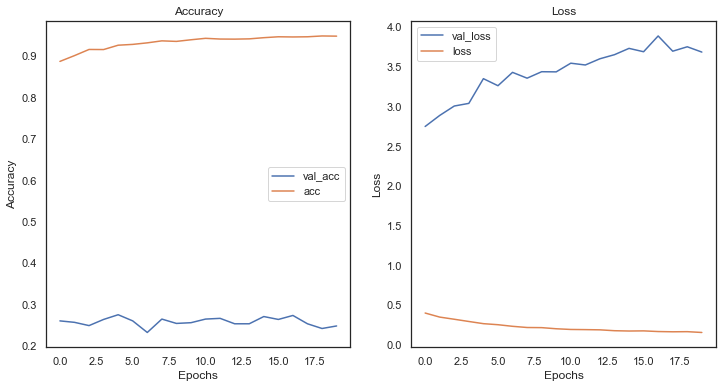

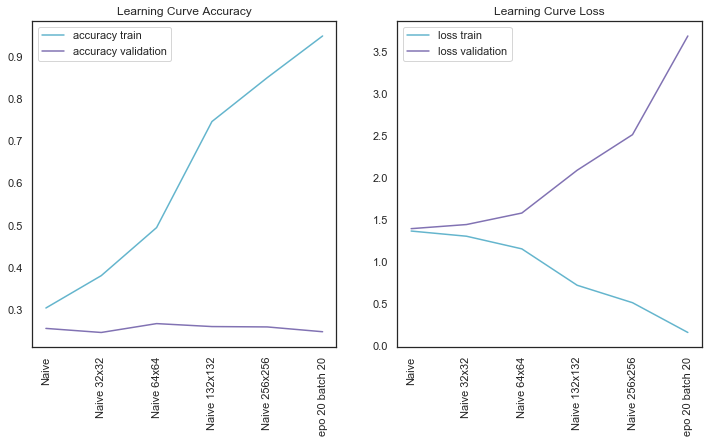

In [53]:
df_res=model_results(model256, history5, 'epo 20 batch 20', df_res, train_images256, train_y)

With longer epochs and a bigger batch, the accuracy of both train and validation has increased.
I will try next with even longer epochs and larger batch, but I will decrease the image size back to 132 to reduce the run time.

In [54]:
history6 = fit_model(model132, train_images132, train_y, epo=50, batch=100, verbose=1)

Epoch 1/50
46/46 [==============================] - 17s 362ms/step - loss: 0.5720 - acc: 0.8151 - val_loss: 2.1929 - val_acc: 0.2668
Epoch 2/50
46/46 [==============================] - 14s 302ms/step - loss: 0.5496 - acc: 0.8194 - val_loss: 2.3597 - val_acc: 0.2458
Epoch 3/50
46/46 [==============================] - 14s 298ms/step - loss: 0.5231 - acc: 0.8304 - val_loss: 2.2916 - val_acc: 0.2528
Epoch 4/50
46/46 [==============================] - 14s 305ms/step - loss: 0.4953 - acc: 0.8426 - val_loss: 2.3513 - val_acc: 0.2546
Epoch 5/50
46/46 [==============================] - 12s 269ms/step - loss: 0.4766 - acc: 0.8450 - val_loss: 2.4664 - val_acc: 0.2520
Epoch 6/50
46/46 [==============================] - 12s 268ms/step - loss: 0.4537 - acc: 0.8569 - val_loss: 2.4746 - val_acc: 0.2415
Epoch 7/50
46/46 [==============================] - 18s 395ms/step - loss: 0.4322 - acc: 0.8691 - val_loss: 2.5220 - val_acc: 0.2555
Epoch 8/50
46/46 [==============================] - 16s 357ms/step - 

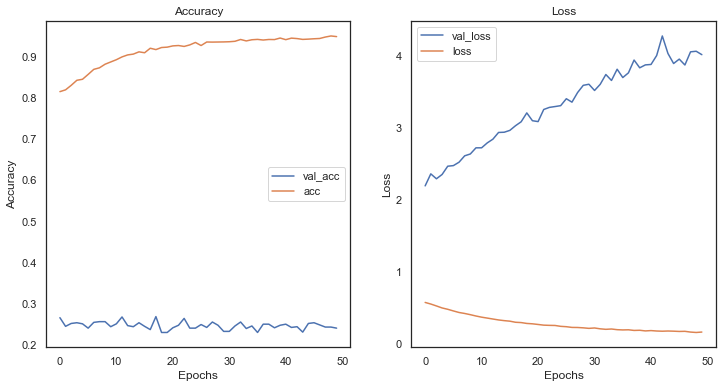

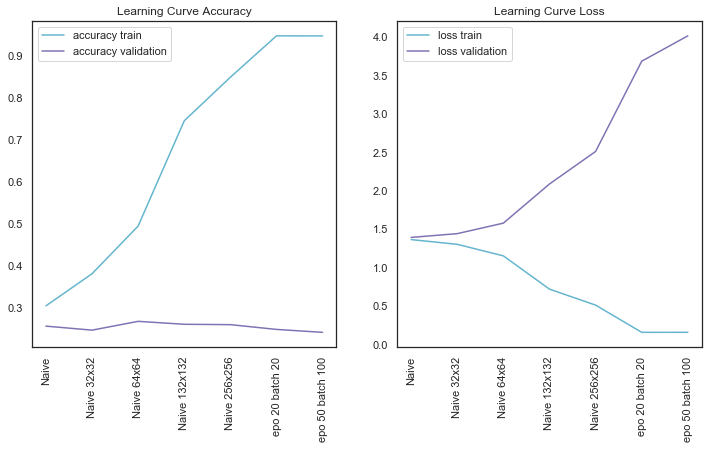

In [55]:
df_res=model_results(model132, history6, 'epo 50 batch 100', df_res, train_images132, train_y)

Good improvement in the accuracy and decrease in the loss. It also seems like after 30 epochs the accuracy starts to plateau.
So next we are going to try to increase just the batch size, leaving the number of epochs at 50.

In [56]:
history7 = fit_model(model132, train_images132, train_y, epo=50, batch=200, verbose=1)

Epoch 1/50
23/23 [==============================] - 16s 682ms/step - loss: 0.1390 - acc: 0.9549 - val_loss: 4.2687 - val_acc: 0.2441
Epoch 2/50
23/23 [==============================] - 12s 541ms/step - loss: 0.1434 - acc: 0.9536 - val_loss: 4.1126 - val_acc: 0.2450
Epoch 3/50
23/23 [==============================] - 24s 1s/step - loss: 0.1449 - acc: 0.9508 - val_loss: 4.1189 - val_acc: 0.2493
Epoch 4/50
23/23 [==============================] - 14s 581ms/step - loss: 0.1439 - acc: 0.9499 - val_loss: 4.1565 - val_acc: 0.2485
Epoch 5/50
23/23 [==============================] - 14s 599ms/step - loss: 0.1419 - acc: 0.9494 - val_loss: 4.1215 - val_acc: 0.2528
Epoch 6/50
23/23 [==============================] - 13s 567ms/step - loss: 0.1380 - acc: 0.9514 - val_loss: 4.3200 - val_acc: 0.2633
Epoch 7/50
23/23 [==============================] - 23s 989ms/step - loss: 0.1392 - acc: 0.9516 - val_loss: 4.1745 - val_acc: 0.2467
Epoch 8/50
23/23 [==============================] - 14s 594ms/step - los

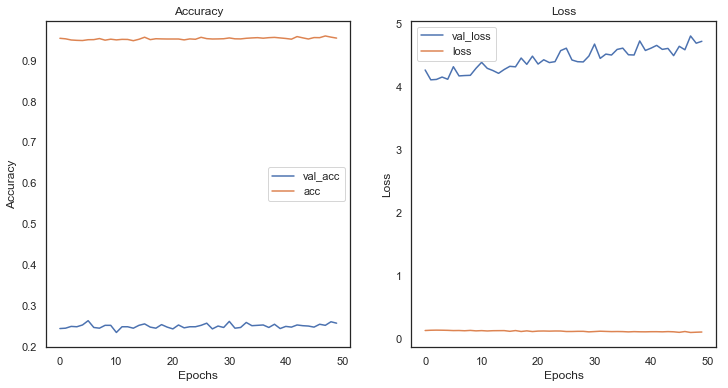

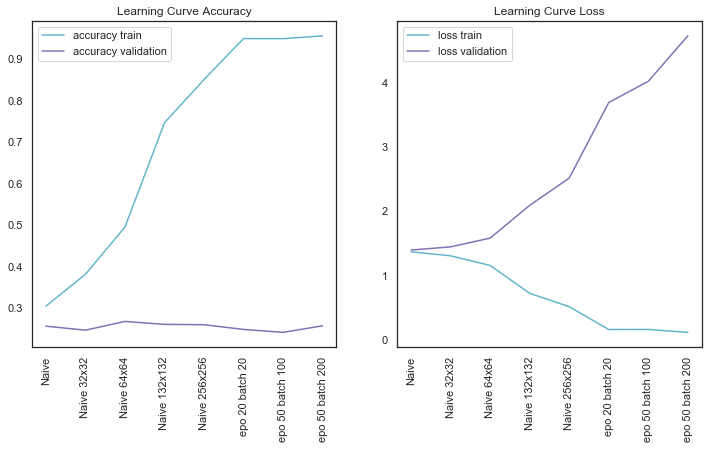

In [57]:
df_res=model_results(model132, history7, 'epo 50 batch 200', df_res, train_images132, train_y)

In [58]:
df_res

,Name,accuracy train,accuracy validation,loss train,loss validation
0,Naive,0.304662,0.256343,1.366258,1.394532
0,Naive 32x32,0.381265,0.246719,1.304591,1.443555
0,Naive 64x64,0.495075,0.267717,1.154185,1.580436
0,Naive 132x132,0.746115,0.260717,0.721201,2.089783
0,Naive 256x256,0.850077,0.259843,0.513660,2.513150
0,epo 20 batch 20,0.948785,0.248469,0.159287,3.687549
0,epo 50 batch 100,0.948566,0.241470,0.160052,4.017348
0,epo 50 batch 200,0.955351,0.257218,0.115134,4.723271


The performance is very similar between using a batch of 100 or 200, so we can keep the 100 now for the purpose of saving time and we can always increase it later on. 
<br>Now we will move on to adding more layers to our model.

In [59]:
# create model
#Sequential: multiple layers built on top of each other

model132 = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(132,132,3)))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(10, (3, 3), activation='relu'))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(20, (3, 3), activation='relu'))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model132.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model132.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model132.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [61]:
history8 = fit_model(model132, train_images132, train_y, epo=50, batch=100, verbose=1)

Epoch 1/50
46/46 [==============================] - 50s 1s/step - loss: 1.3846 - acc: 0.2769 - val_loss: 1.3842 - val_acc: 0.2835
Epoch 2/50
46/46 [==============================] - 64s 1s/step - loss: 1.3811 - acc: 0.2887 - val_loss: 1.3859 - val_acc: 0.2607
Epoch 3/50
46/46 [==============================] - 90s 2s/step - loss: 1.3759 - acc: 0.2957 - val_loss: 1.3913 - val_acc: 0.2555
Epoch 4/50
46/46 [==============================] - 82s 2s/step - loss: 1.3650 - acc: 0.3180 - val_loss: 1.4013 - val_acc: 0.2642
Epoch 5/50
46/46 [==============================] - 39s 859ms/step - loss: 1.3560 - acc: 0.3143 - val_loss: 1.3923 - val_acc: 0.2668
Epoch 6/50
46/46 [==============================] - 107s 2s/step - loss: 1.3430 - acc: 0.3493 - val_loss: 1.3962 - val_acc: 0.2563
Epoch 7/50
46/46 [==============================] - 33s 726ms/step - loss: 1.3278 - acc: 0.3747 - val_loss: 1.4195 - val_acc: 0.2476
Epoch 8/50
46/46 [==============================] - 32s 693ms/step - loss: 1.3096 -

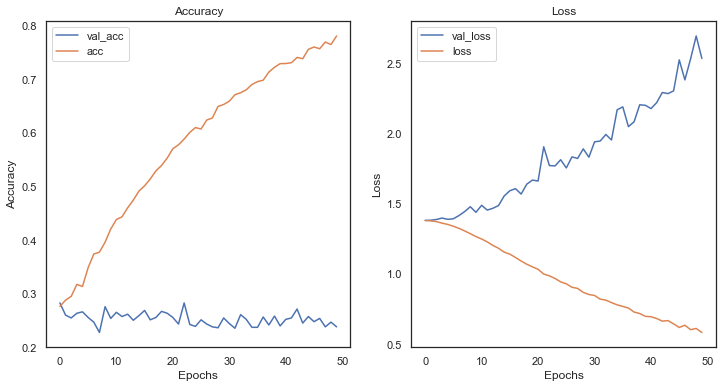

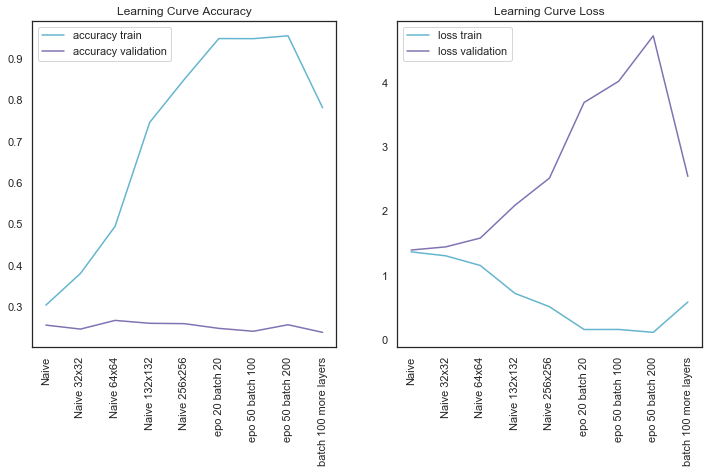

In [62]:
df_res=model_results(model132, history8, 'batch 100 more layers', df_res, train_images132, train_y)

From these results it seems like the performance of the model actually went down.
This begs the question if this is a problem of the model or of the size of the batch, so we will repeat with the 200 batch size.

In [63]:
history9 = fit_model(model132, train_images132, train_y, epo=50, batch=200, verbose=1)

Epoch 1/50
23/23 [==============================] - 50s 2s/step - loss: 0.5482 - acc: 0.7989 - val_loss: 2.5527 - val_acc: 0.2528
Epoch 2/50
23/23 [==============================] - 51s 2s/step - loss: 0.5692 - acc: 0.7923 - val_loss: 2.5808 - val_acc: 0.2528
Epoch 3/50
23/23 [==============================] - 36s 2s/step - loss: 0.5555 - acc: 0.7975 - val_loss: 2.7369 - val_acc: 0.2686
Epoch 4/50
23/23 [==============================] - 33s 1s/step - loss: 0.5624 - acc: 0.7916 - val_loss: 2.5084 - val_acc: 0.2502
Epoch 5/50
23/23 [==============================] - 38s 2s/step - loss: 0.5466 - acc: 0.7938 - val_loss: 2.5643 - val_acc: 0.2625
Epoch 6/50
23/23 [==============================] - 50s 2s/step - loss: 0.5355 - acc: 0.8061 - val_loss: 2.6401 - val_acc: 0.2467
Epoch 7/50
23/23 [==============================] - 42s 2s/step - loss: 0.5250 - acc: 0.8035 - val_loss: 2.9305 - val_acc: 0.2502
Epoch 8/50
23/23 [==============================] - 45s 2s/step - loss: 0.5194 - acc: 0.80

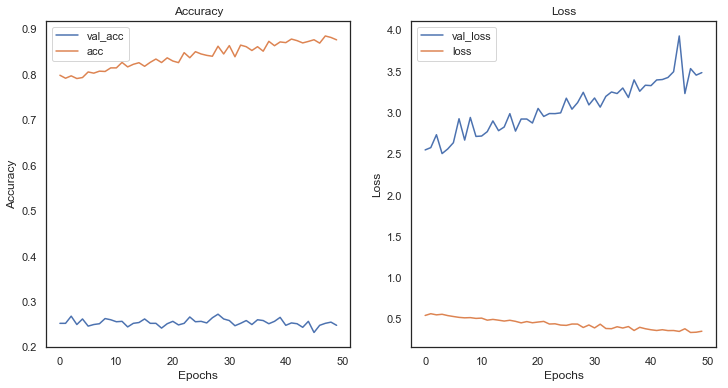

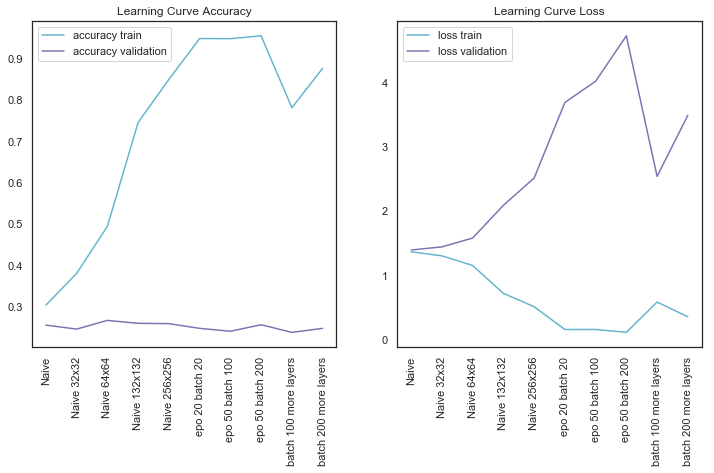

In [64]:
df_res=model_results(model132, history9, 'batch 200 more layers', df_res, train_images132, train_y)

We see an improvement in accuracy with the 200 batch.
We will keep that from now on.
#### Optimization algorithm
Next we will move on to tune other parameters, starting from the optimization algorithm. The most popular and known optimization algorithms are RMS prop, SGD and Adam.
We have been using RMS propo so far so let's try the other two.

In [65]:
# create model
#Sequential: multiple layers built on top of each other

model132 = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(132,132,3)))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(10, (3, 3), activation='relu'))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(20, (3, 3), activation='relu'))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model132.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model132.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model132.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

In [66]:
history10 = fit_model(model132, train_images132, train_y, epo=50, batch=200, verbose=1)

Epoch 1/50
23/23 [==============================] - 48s 2s/step - loss: 1.3884 - acc: 0.2416 - val_loss: 1.3854 - val_acc: 0.2476
Epoch 2/50
23/23 [==============================] - 53s 2s/step - loss: 1.3864 - acc: 0.2667 - val_loss: 1.3838 - val_acc: 0.2677
Epoch 3/50
23/23 [==============================] - 44s 2s/step - loss: 1.3859 - acc: 0.2678 - val_loss: 1.3831 - val_acc: 0.2791
Epoch 4/50
23/23 [==============================] - 37s 2s/step - loss: 1.3841 - acc: 0.2790 - val_loss: 1.3828 - val_acc: 0.2791
Epoch 5/50
23/23 [==============================] - 38s 2s/step - loss: 1.3844 - acc: 0.2798 - val_loss: 1.3826 - val_acc: 0.2808
Epoch 6/50
23/23 [==============================] - 56s 2s/step - loss: 1.3832 - acc: 0.2836 - val_loss: 1.3826 - val_acc: 0.2782
Epoch 7/50
23/23 [==============================] - 48s 2s/step - loss: 1.3821 - acc: 0.2846 - val_loss: 1.3826 - val_acc: 0.2782
Epoch 8/50
23/23 [==============================] - 34s 1s/step - loss: 1.3836 - acc: 0.28

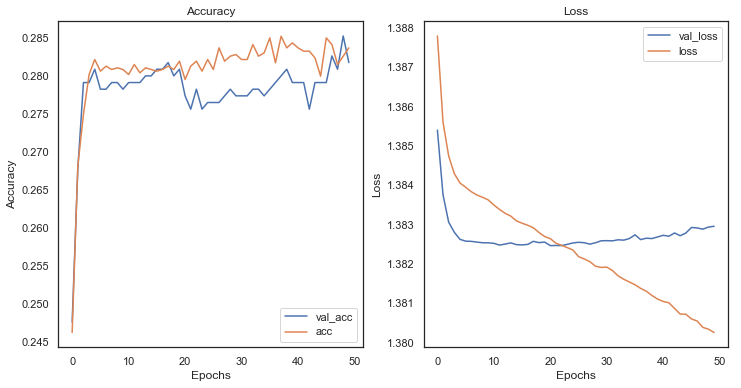

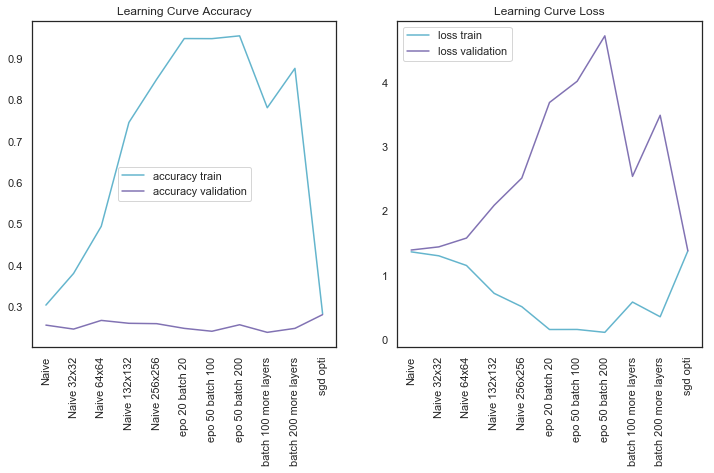

In [67]:
df_res=model_results(model132, history10, 'sgd opti', df_res, train_images132, train_y)

We can see how with the sgd optimizer the performance of the model definitely decreases, so let us move on and try with Adam instead.

In [68]:
# create model
#Sequential: multiple layers built on top of each other

model132 = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(132,132,3)))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(10, (3, 3), activation='relu'))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(20, (3, 3), activation='relu'))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model132.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model132.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model132.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [69]:
history11 = fit_model(model132, train_images132, train_y, epo=50, batch=200, verbose=1)

Epoch 1/50
23/23 [==============================] - 57s 2s/step - loss: 1.3870 - acc: 0.2739 - val_loss: 1.3845 - val_acc: 0.2721
Epoch 2/50
23/23 [==============================] - 56s 2s/step - loss: 1.3830 - acc: 0.2822 - val_loss: 1.3839 - val_acc: 0.2773
Epoch 3/50
23/23 [==============================] - 39s 2s/step - loss: 1.3779 - acc: 0.2919 - val_loss: 1.3862 - val_acc: 0.2633
Epoch 4/50
23/23 [==============================] - 38s 2s/step - loss: 1.3756 - acc: 0.2928 - val_loss: 1.3847 - val_acc: 0.2913
Epoch 5/50
23/23 [==============================] - 29s 1s/step - loss: 1.3647 - acc: 0.3154 - val_loss: 1.3823 - val_acc: 0.2817
Epoch 6/50
23/23 [==============================] - 31s 1s/step - loss: 1.3600 - acc: 0.3252 - val_loss: 1.3908 - val_acc: 0.2738
Epoch 7/50
23/23 [==============================] - 40s 2s/step - loss: 1.3468 - acc: 0.3299 - val_loss: 1.3989 - val_acc: 0.2563
Epoch 8/50
23/23 [==============================] - 33s 1s/step - loss: 1.3294 - acc: 0.36

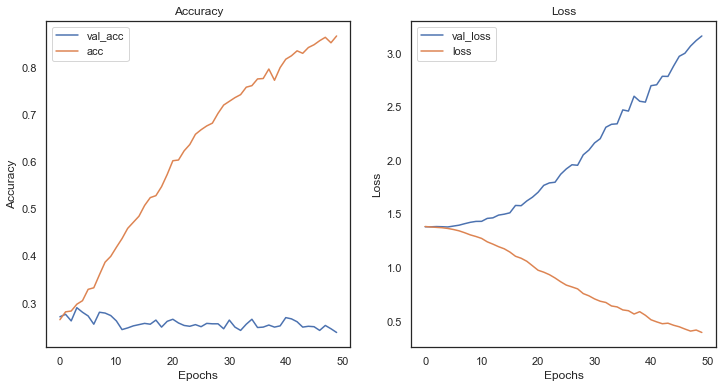

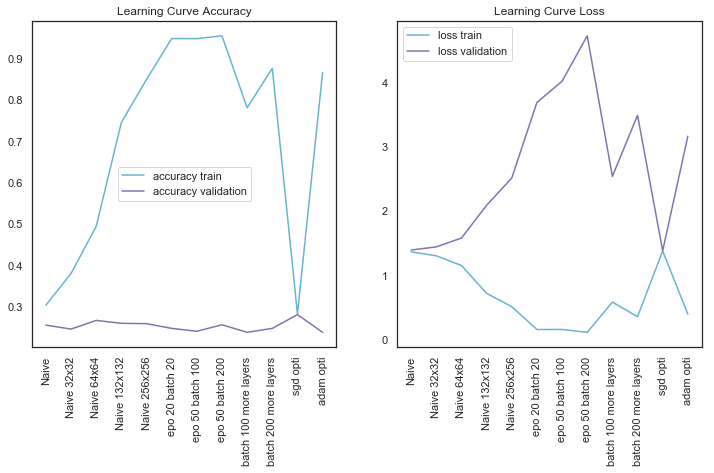

In [70]:
df_res=model_results(model132, history11, 'adam opti', df_res, train_images132, train_y)

The adam optimizer clearly worked better.
Let us try also with Adamax.

In [71]:
# create model
#Sequential: multiple layers built on top of each other

model132 = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(132,132,3)))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(10, (3, 3), activation='relu'))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model132.add(layers.Conv2D(20, (3, 3), activation='relu'))
#MaxPooling with filter size 2 and stride 2
model132.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model132.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model132.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model132.compile(loss='sparse_categorical_crossentropy',
              optimizer='adamax',
              metrics=['acc'])

In [72]:
history12 = fit_model(model132, train_images132, train_y, epo=50, batch=200, verbose=1)

Epoch 1/50
23/23 [==============================] - 56s 2s/step - loss: 1.3950 - acc: 0.2538 - val_loss: 1.3864 - val_acc: 0.2738
Epoch 2/50
23/23 [==============================] - 46s 2s/step - loss: 1.3850 - acc: 0.2663 - val_loss: 1.3845 - val_acc: 0.2721
Epoch 3/50
23/23 [==============================] - 34s 1s/step - loss: 1.3823 - acc: 0.2828 - val_loss: 1.3840 - val_acc: 0.2686
Epoch 4/50
23/23 [==============================] - 32s 1s/step - loss: 1.3791 - acc: 0.2879 - val_loss: 1.3855 - val_acc: 0.2651
Epoch 5/50
23/23 [==============================] - 33s 1s/step - loss: 1.3781 - acc: 0.2930 - val_loss: 1.3848 - val_acc: 0.2765
Epoch 6/50
23/23 [==============================] - 32s 1s/step - loss: 1.3764 - acc: 0.3039 - val_loss: 1.3867 - val_acc: 0.2660
Epoch 7/50
23/23 [==============================] - 38s 2s/step - loss: 1.3735 - acc: 0.2888 - val_loss: 1.3869 - val_acc: 0.2826
Epoch 8/50
23/23 [==============================] - 34s 1s/step - loss: 1.3712 - acc: 0.30

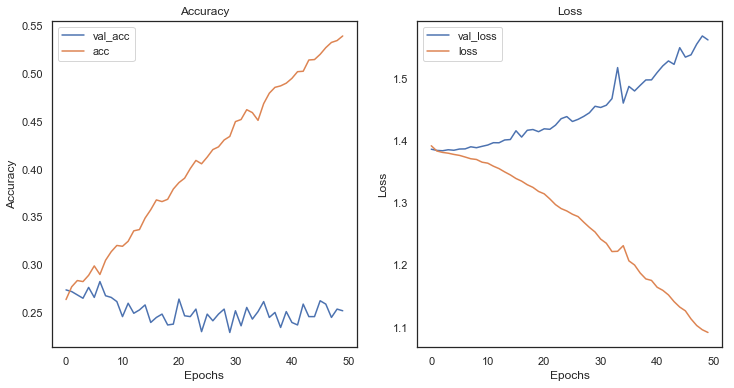

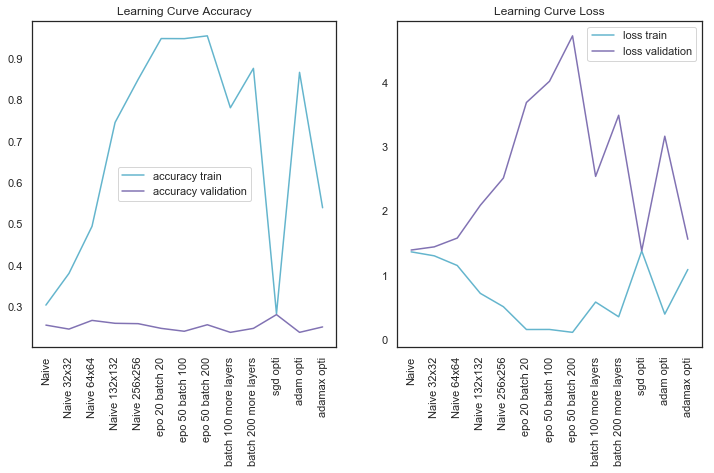

In [73]:
df_res=model_results(model132, history12, 'adamax opti', df_res, train_images132, train_y)